<a href="https://colab.research.google.com/github/Seo-Hongju/Hong_test_git01/blob/master/kaggle_notebook_%EC%84%9C%ED%99%8D%EC%A3%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/expedia-hotel-recommendations/train.csv
/kaggle/input/expedia-hotel-recommendations/destinations.csv
/kaggle/input/expedia-hotel-recommendations/test.csv
/kaggle/input/expedia-hotel-recommendations/sample_submission.csv


In [0]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import seaborn as sns
print(os.listdir("/kaggle/input"))

['expedia-hotel-recommendations']


In [0]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [15, 7]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [0]:
!head -n 5 /kaggle/input/expedia-hotel-recommendations/train.csv

date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-27,2014-08-31,2,0,1,8250,1,0,3,2,50,628,1
2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-29,2014-09-02,2,0,1,8250,1,1,1,2,50,628,1
2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,9,2014-08-29,2014-09-02,2,0,1,8250,1,0,1,2,50,628,1
2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,3,2014-11-23,2014-11-28,2,0,1,14984,1,0,1,2,50,1457,80


In [0]:
!wc -l /kaggle/input/expedia-hotel-recommendations/train.csv

37670294 /kaggle/input/expedia-hotel-recommendations/train.csv


In [0]:
data = pd.read_csv("/kaggle/input/expedia-hotel-recommendations/train.csv", nrows=100000)

# Goals 목표:
- Hotel_clusters are dependent on which categorical variable?
호텔 군집은 어떤 범주형 변수에 의존하는가?
    - Graph the top 4 도표의 상위 4개
- Hotel_clusters are dependent on which numerical variable?
호텔 군집은 어떤 숫자 변수에 의존하는가?
- How correlated are the user's country to the hotel's country? Continent?
사용자의 나라와 호텔의 나라, 혹은 대륙은 어떤 상관관계를 갖고 있는가?

# Models to check out 확인해야 할 모델
- The closest 5 hotels in the latent space clicked by each person should be recommended at the top 5 (Content-based filtering)
각 사용자가 클릭한 잠재 공간에서 가장 가까운 5 개의 호텔을 상위 5 로 추천해야한다 (콘텐츠 기반 필터링).
- Create a pairwise ranking matrix factorization model of user to hotel cluster (Collaborative filtering)
사용자와 호텔 군집의 쌍별 순위 행렬 인수 분해 모델 작성하기 (협업 필터링)
- Factorization machine of the dependent categoricals and numericals (Hybrid)
종속 범주 및 숫자의 인수 분해 기계 (하이브리드)

## * 컬럼 내용
#### 범주 = [site_name : Expedia 판매 시점의 ID(사용자가 사용한 사이트 국가), posa_continent : site_name과 연관된 대륙의 ID, user_location_country : 사용자가 위치한 국가의 ID, user_location_region : 사용자가 위치한 지역의 ID, user_location_city : 사용자가 위치한 도시의 ID, is_mobile :사용자가 모바일 장치에서 연결한 경우 1, 아니라면 0, is_package : 클릭, 예약이 패키지의 일부로 생성된 경우(항공편과 결합시) 1, 아니라면 0, channel : 마케팅 채널의 ID,srch_destination_type_id : 목적지 유형, hotel_continent : 호텔 대륙, hotel_country : 호텔 국가, hotel_market : 호텔 마켓, srch_destination_id : 호텔 검색이 수행된 목적지의 ID]

숫자 = [orig_destination_distance : 검색시 호텔과 고객간의 물리적 거리. Null은 거리를 계산 할 수 없음의 의미, srch_adults_cnt : 호텔 객실에 지정된 성인 수, srch_rm : 검색에 지정된 호텔 객실 수, cnt : 총 인원수]

사용자 ID = [user_id : 사용자의 ID]
예약여부 = [is_booking :  예약인 경우 1, 아니라면 0]
호텔 군집 = [hotel_cluster : 호텔 그룹,군집]

In [0]:
CATEGORICALS = ["site_name", "posa_continent", "user_location_country", "user_location_region", "user_location_city", "is_mobile", "is_package", "channel", 
               "srch_destination_type_id", "hotel_continent", "hotel_country", "hotel_market", "srch_destination_id"]
NUMERICALS = ["orig_destination_distance", "srch_adults_cnt", "srch_children_cnt", "srch_rm_cnt", "cnt"]
USER_ID = "user_id"
IS_BOOKING = "is_booking"
HOTEL_CLUSTER = "hotel_cluster"

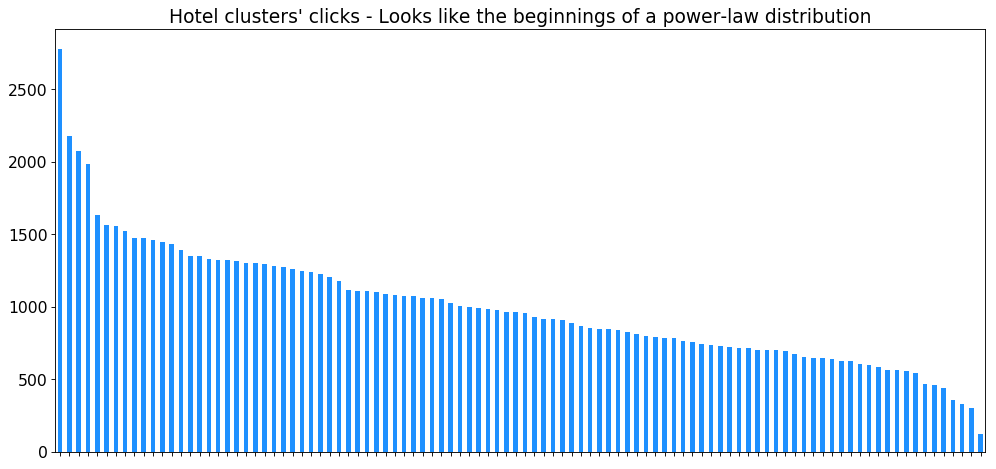

In [0]:
ax = data[HOTEL_CLUSTER].value_counts().plot.bar(color='dodgerblue')
ax.set_xticklabels([])
plt.title("Hotel clusters' clicks - Looks like the beginnings of a power-law distribution");

In [0]:
data_cat_dummies = pd.get_dummies(pd.get_dummies(data[CATEGORICALS].astype('category')))

In [0]:
def name_scores(featurecoef, col_names, label="Score", sort=False):
    df_feature_importance = pd.DataFrame([dict(zip(col_names, featurecoef))]).T.reset_index()
    df_feature_importance.columns = ["Feature", label]
    if sort:
        return df_feature_importance.sort_values(ascending=False, by=label)
    return df_feature_importance

In [0]:
from sklearn.feature_selection import chi2

sample_n = 10000
data_cat_dummies_sample = data_cat_dummies.sample(sample_n)
chi2_scores = chi2(data_cat_dummies_sample, data[HOTEL_CLUSTER].loc[data_cat_dummies_sample.index])
df_chi2_scores = name_scores(chi2_scores[0], data_cat_dummies_sample.columns)
df_chi2_scores = df_chi2_scores.sort_values(by="Score", ascending=False)

In [0]:
# get the top 100 features and graph the categorical
# 상위 100개를 뽑은 후 그래프로 범주화한다.
n = 100
top_n_features = df_chi2_scores[:n]["Feature"]

In [0]:
top_n_features.apply(lambda s : ' '.join(s.split("_")[:len(s.split("_"))-1])).value_counts()

hotel market             31
srch destination id      28
hotel country            17
user location city        9
hotel continent           6
user location country     3
posa continent            2
user location region      2
is package                1
site name                 1
Name: Feature, dtype: int64

* The graph below gets the features whose dummy variables contain the most entries in the top 100 by chi2 scores.
아래 그래프는 더미 변수가 chi2 scores로 상위 100 개의 항목을 가장 많이 포함하는 기능을 보여준다.
* Let's graph hotel market, country and user's city with respect to the hotel clusters.
호텔 클러스터와 관련하여 호텔 시장, 국가 및 사용자 도시를 그래프로 나타내겠다.
* We'll dedicate a section for srch_destination_id, but that seems very relevant.
srch_destination_id에 대한 섹션을 제공할 것이고 이는 매우 관련성이있는 것으로 보인다.
* For ease of readability, we'll only get the top 5 hotel_clusters, their market, country and user location.
쉽게 읽을 수 있도록 상위 5 개의 hotel_clusters, 시장, 국가 및 사용자 위치만을 뽑아낼 것이다.

## Some basic findings 기본적인 발견 몇가지
- Looks like user city ~17 and ~90 is very active all throughout the different hotel clusters
사용자 도시 ~ 17과 ~ 90은 다른 호텔 클러스터 전체에서 매우 활발한 것처럼 보인다.
- Looks like hotel_market ~59 and 62 are related to many hotel_clusters
 hotel_market ~ 59 및 62가 많은 hotel_clusters와 관련이있는 것 같다.
- Looks like hotel_country ~8 is related to many hotel_clusters
hotel_country ~ 8은 많은 hotel_clusters와 관련이 있다.

In [0]:
def create_matrix(data, group_column, val_column):
    grouped_data = data.groupby(group_column)[val_column].value_counts()
    grouped_data = grouped_data.groupby(level=0).nlargest(3)
    grouped_data.index = grouped_data.index.droplevel(0)
    # transfrom to a square matrix
    grouped_data_unstacked = grouped_data.unstack()
    return grouped_data_unstacked.fillna(0)

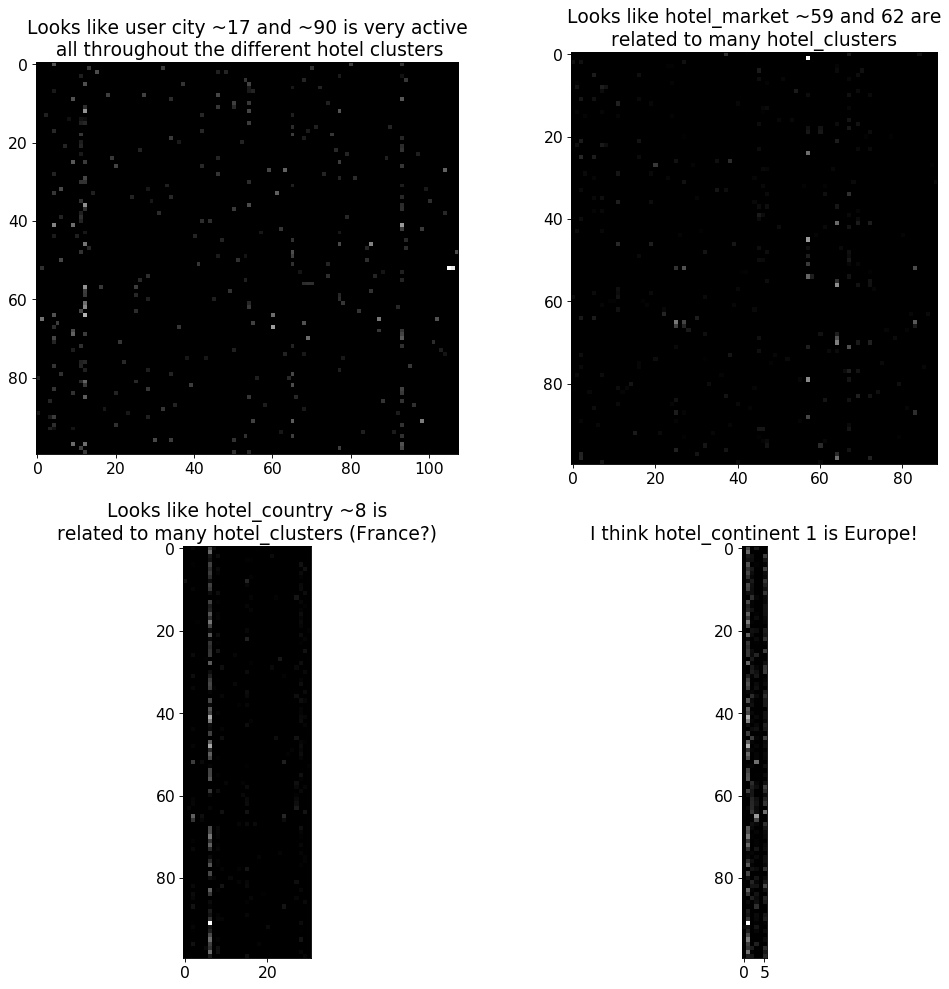

In [0]:
hotel_user_city_vc_matrix = create_matrix(data, "hotel_cluster", "user_location_city")
hotel_market_vc_matrix = create_matrix(data, "hotel_cluster", "hotel_market")
hotel_country_vc_matrix = create_matrix(data, "hotel_cluster", "hotel_country")
hotel_continent_vc_matrix = create_matrix(data, "hotel_cluster", "hotel_continent")

# hotel user city
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

axes[0][0].set_title("Looks like user city ~17 and ~90 is very active\n all throughout the different hotel clusters")
axes[0][0].imshow(hotel_user_city_vc_matrix, cmap='gray')

axes[0][1].set_title("Looks like hotel_market ~59 and 62 are\nrelated to many hotel_clusters")
axes[0][1].imshow(hotel_market_vc_matrix, cmap='gray')

axes[1][0].set_title("Looks like hotel_country ~8 is\nrelated to many hotel_clusters (France?)")
axes[1][0].imshow(hotel_country_vc_matrix, cmap='gray');

axes[1][1].set_title("I think hotel_continent 1 is Europe!")
axes[1][1].imshow(hotel_continent_vc_matrix, cmap='gray');

# Numericals 숫자
- Since orig_destination_distance has null values, let's see its distribution then decide on the imputation method.
orig_destination_distance(사용자와 호텔 간의 물리적 거리)에 null 값이 있으므로 분포를 확인한 후 대치 방법을 결정하겠다.

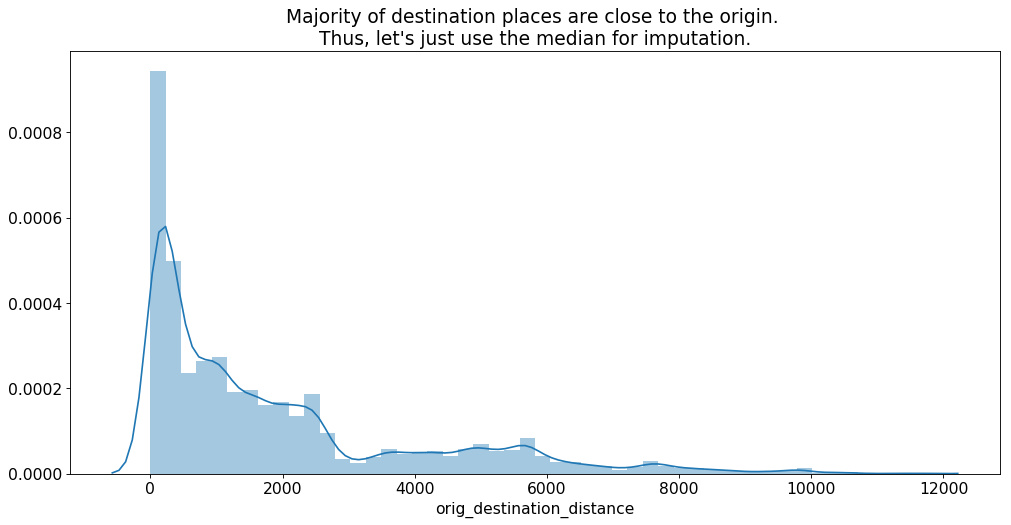

In [0]:
sns.distplot(data["orig_destination_distance"].dropna())

plt.title("Majority of destination places are close to the origin. \nThus, let's just use the median for imputation.");

In [0]:
sample_n = 10000
data_numericals_sample = data[NUMERICALS].sample(sample_n)
chi2_scores = chi2(data_numericals_sample.fillna(data_numericals_sample.median()), data[HOTEL_CLUSTER].loc[data_numericals_sample.index])
df_chi2_scores = name_scores(chi2_scores[0], data_numericals_sample.columns)

df_chi2_pvalues = name_scores(chi2_scores[1], data_numericals_sample.columns)
df_chi2_pvalues.columns = ["Feature", "PValue"]

df_chi2_scores.merge(df_chi2_pvalues).sort_values(by="Score", ascending=False)

,Feature,Score,PValue
0,orig_destination_distance,1.983011e+06,0.000000e+00
2,srch_children_cnt,4.381255e+02,3.547305e-44
4,cnt,1.292376e+02,2.228656e-02
1,srch_adults_cnt,7.567760e+01,9.608522e-01
3,srch_rm_cnt,2.942445e+01,1.000000e+00


### Hypotheses: 가설
- Distance is important to travelers. Hotel clusters seem to be dependent on the distance.
거리는 여행자에게 중요합니다. 호텔 클러스터는 거리에 의존하는 것 같다.
- Certain hotel clusters seem to be children friendly
특정 호텔 클러스터는 유아친화적인 것 같다.
- Certain hotel_clusters seem also to rake in "bandwagoners" (thru cnt variable)
특정 hotel_clusters는 1위만을 쫓는 사람들을 끌고 오는 것 같다.(cnt 변수를 통해)

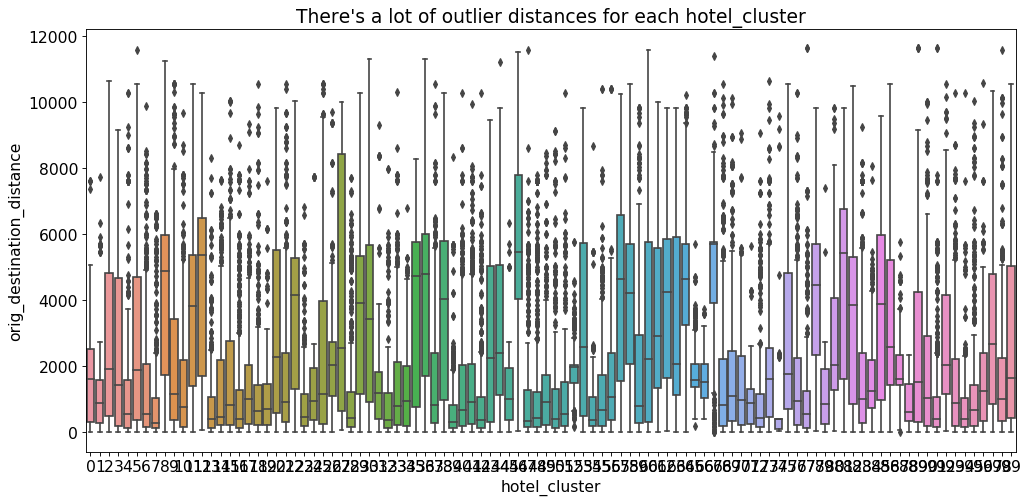

In [0]:
sns.boxplot(data=data, x=HOTEL_CLUSTER, y="orig_destination_distance")

plt.title("There's a lot of outlier distances for each hotel_cluster");

In [0]:
data_cluster = data[[HOTEL_CLUSTER]].copy()
data_cluster["cluster_num"] = pd.cut(data_cluster[HOTEL_CLUSTER], bins=4, labels=range(4))

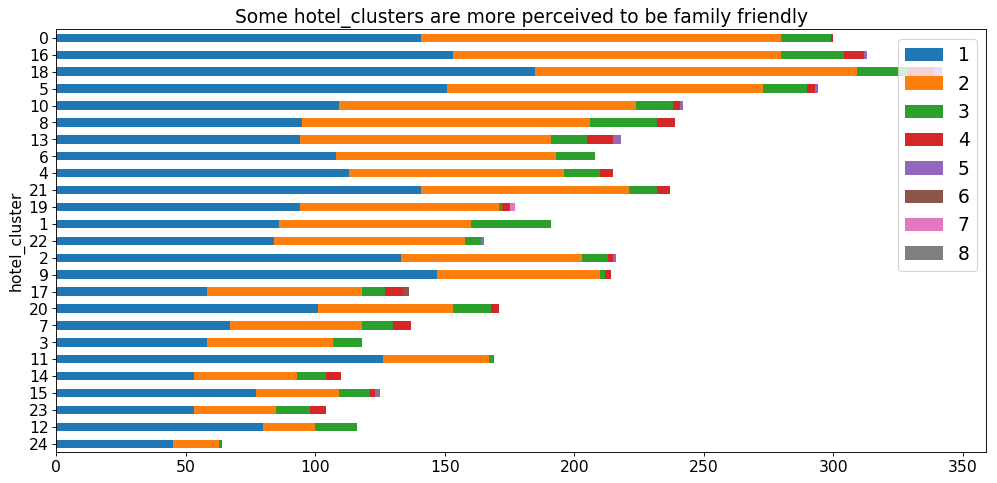

In [0]:
clusters_1 = data[data[HOTEL_CLUSTER].isin(data_cluster.loc[data_cluster["cluster_num"] == 0, HOTEL_CLUSTER])]
clusters_1_unstacked = clusters_1.groupby(HOTEL_CLUSTER)["srch_children_cnt"].value_counts().unstack().fillna(0)

clusters_1_unstacked= clusters_1_unstacked.drop(0, axis=1).sort_values(by=2,)
ax = clusters_1_unstacked.plot.barh(stacked=True)
ax.legend(loc='upper right')

plt.title("Some hotel_clusters are more perceived to be family friendly", );

# What is the relationship of srch_destination_id to hotel_clusters?
srch_destination_id와 hotel_clusters의 관계는 무엇인가?

In [0]:
print("Search destination id's nunique: ", data["srch_destination_id"].nunique())
print("Search destination types nunique: ", data["srch_destination_type_id"].nunique())

Search destination id's nunique:  5296
Search destination types nunique:  8


## For each hotel cluster, how is srch type related?
각 호텔 클러스터마다 srch 유형은 어떤 관련이 있는가?

Looks like the search types tend around 1 and 6.


srch_destination_type_id,1,3,4,5,6,8
hotel_cluster,,,,,,
0,594.0,168.0,0.0,0.0,157.0,0.0
1,671.0,0.0,0.0,16.0,373.0,0.0
2,841.0,0.0,0.0,50.0,258.0,0.0
3,349.0,60.0,0.0,0.0,148.0,0.0
4,504.0,0.0,0.0,71.0,270.0,0.0
5,915.0,114.0,0.0,0.0,407.0,0.0
6,628.0,0.0,0.0,123.0,277.0,0.0
7,392.0,82.0,0.0,0.0,171.0,0.0
8,597.0,0.0,0.0,53.0,238.0,0.0


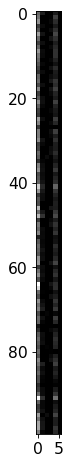

In [0]:
hotel_search_type_matrix = create_matrix(data, HOTEL_CLUSTER, "srch_destination_type_id")
print("Looks like the search types tend around 1 and 6.")
display(hotel_search_type_matrix[:10])
plt.imshow(hotel_search_type_matrix, cmap='gray');

## For each hotel cluster, how is search_id related. How many unique search ids are there for each hotel cluster?
각 호텔 클러스터에 대해 search_id는 어떻게 관련되어 있는가? 각 호텔 클러스터마다 몇 개의 고유한 검색 ID가 있나?

- Seems like there is a non-trivial amount of search id of just 1. These may be the "weird" searches that corresponded to some hotel clusters.
적은 양의 검색 ID가 1인 것처럼 보인다. 이는 일부 호텔 클러스터에 해당하는 이상한 검색일 수 있다.
- On the other hand, there's a lot of search ids per hotel cluster. Seems we can work with this for our content-based filtering algorithm. We can spend time tweaking embeddings for each hotel clsuter. Or we can just average them out.
반면에 호텔 클러스터당 많은 검색 ID가 있다. 콘텐츠 기반 필터링 알고리즘을 위해 이 작업을 수행 할 수 있다. 각 호텔 클러스터의 임베딩을 조정하는 데 시간을 할애할 수 있다. 아니면 그냥 평균을 내릴 수도 있다.

,Stats of the number of unique search IDs per hotel cluster
count,100.000000
mean,258.330000
std,148.070421
min,5.000000
25%,156.500000
50%,272.000000
75%,336.750000
max,811.000000


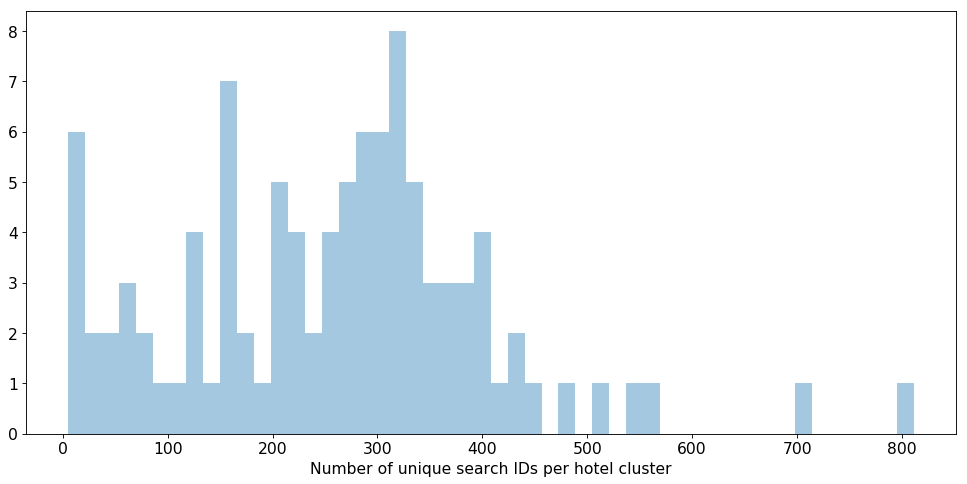

In [0]:
hotel_to_search_n = data.groupby(HOTEL_CLUSTER)["srch_destination_id"].nunique()
ax = sns.distplot(hotel_to_search_n, bins=50, kde=False)
ax.set_xlabel("Number of unique search IDs per hotel cluster")

display(data.groupby(HOTEL_CLUSTER)["srch_destination_id"].nunique().describe().to_frame(
    "Stats of the number of unique search IDs per hotel cluster"))

# Latent space variables look like a 10-20 'expressed' variables out of a hundred fifty
잠재 공간 변수는 150개 중 10-20 개의 명시된 변수처럼 보인다.

In [0]:
destinations = pd.read_csv("/kaggle/input/expedia-hotel-recommendations/destinations.csv")

In [0]:
def create_latent_search_img(index, ax):
    # to make the image 10x15, we create a 150th feature with the mean of the array
    img = np.array(destinations.loc[index].values[1:].tolist() + [destinations.loc[index].values[1:].mean()])
    img = img.reshape((15,10))
    sns.heatmap(img, cmap='gray', ax=ax)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return ax

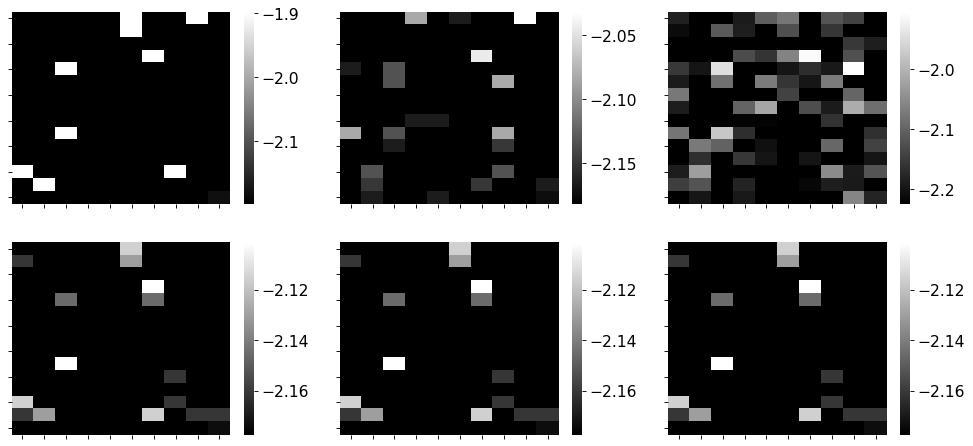

In [0]:
ax1 = create_latent_search_img(0, plt.subplot(2, 3, 1))
ax2 = create_latent_search_img(1, plt.subplot(2, 3, 2))
ax3 = create_latent_search_img(2, plt.subplot(2, 3, 3))
ax4 = create_latent_search_img(3, plt.subplot(2, 3, 4))
ax5 = create_latent_search_img(3, plt.subplot(2, 3, 5))
ax6 = create_latent_search_img(3, plt.subplot(2, 3, 6))

# Let's average out the search ids per hotel cluster
호텔 클러스터당 검색 ID를 평균합니다.

- Keep in mind the minimum number of unique search ids per hotel_cluster is 5, so we should have unique "feature images" per hotel_cluster.
hotel_cluster당 최소 고유 검색 ID 수는 5개이므로 hotel_cluster당 고유한 "기능 이미지"가 있어야한다.
- When we search, we may click or not click on a hotel cluster. We take into account that act of clicking, which means the more search ids associated to a hotel_cluster, the more expressed the variables of those ids should be.
검색 할 때 호텔 클러스터를 클릭하거나 클릭하지 않을 수 있다. 클릭 행위를 고려한다. 즉, hotel_cluster와 관련된 검색 ID가 많을수록 해당 ID의 변수가 더 많이 표현되어야한다.
   - We can either make this a sum or weighted mean aggregation operation. This can be for exploration in the modeling stage.
이것을 합산 또는 가중 평균 집계 연산으로 만들 수 있다. 모델링 단계에서 탐색 할 수 있다.
   - For now, we'll do a sum.
   일단, 합계토록 한다.

In [0]:
def get_latent_search_hotel_array(hotel_cluster_index):
    values = data.loc[data[HOTEL_CLUSTER] == hotel_cluster_index, "srch_destination_id"].to_frame().merge(destinations)
    values = values.drop("srch_destination_id", axis=1)
    values = values.sum()
    return values

def create_latent_search_hotel_image(hotel_cluster_index, ax):
    img = get_latent_search_hotel_array(hotel_cluster_index)
    img = np.array(img.tolist() + [img.mean()])
    img = img.reshape((15,10))
    
    ax.imshow(img, cmap='gray')
    ax.set_title("Cluster " + str(hotel_cluster_index))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return ax

In [0]:
hotel_arrays = []
for i in range(data[HOTEL_CLUSTER].nunique()):
    hotel_arrays.append(get_latent_search_hotel_array(i))
hotel_arrays = np.array(hotel_arrays)

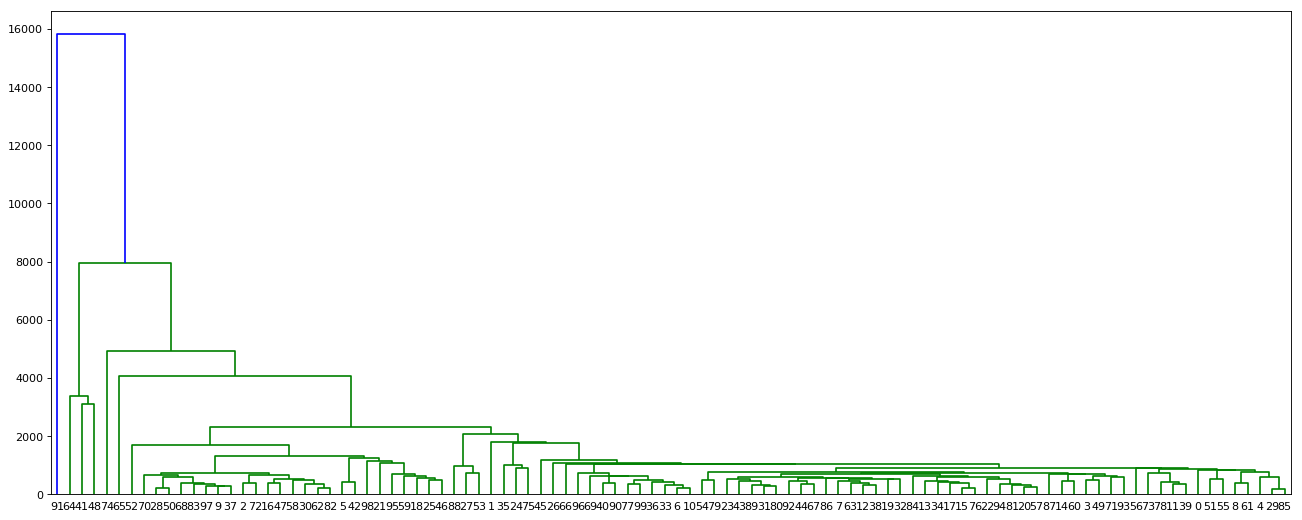

In [0]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

Z = hierarchy.linkage(hotel_arrays, 'single')
plt.figure(figsize=(20, 8))
dn = hierarchy.dendrogram(Z)

# We change the fontsize of minor ticks label 
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation=0)
plt.show()

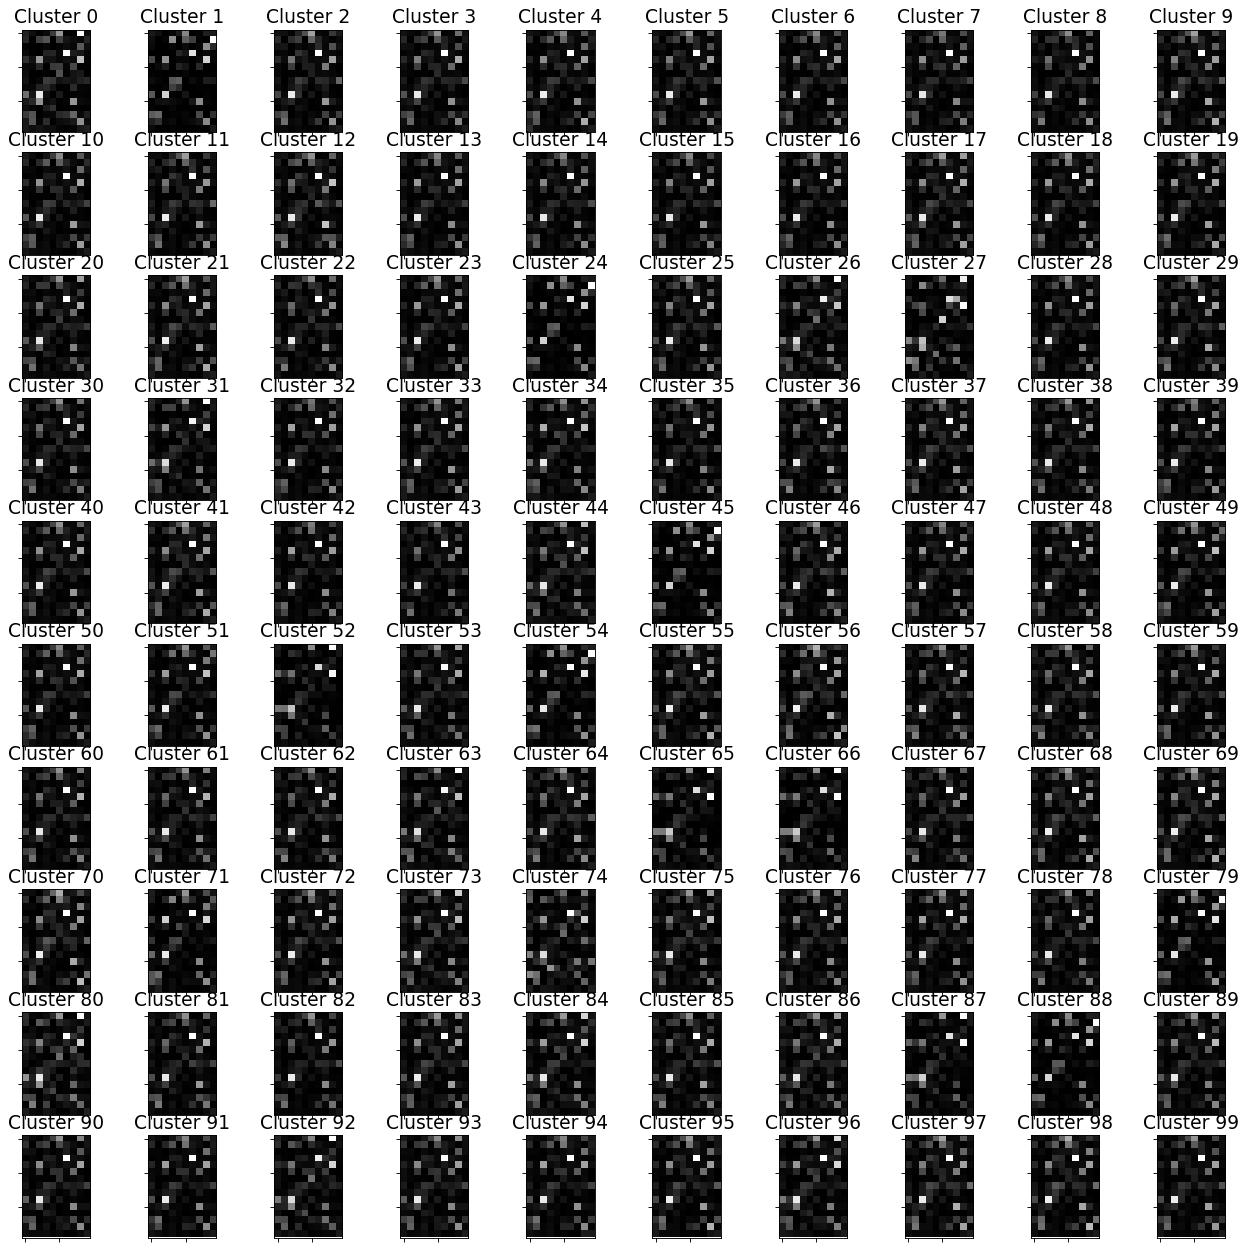

In [0]:
fig = plt.figure(figsize=(20, 20))

for i in range(data[HOTEL_CLUSTER].nunique()):
    create_latent_search_hotel_image(i, fig.add_subplot(10, 10, i+1))

# Analysis: 분석
There's some minute differences across clusters although there are the same latent variables that are always expressed.
항상 표현되는 동일한 잠재 변수가 있지만 군집마다 약간의 차이가 있습니다.
From the dendrogram, some clusters are very close while those on the left seem very unique.
덴드로그램(트리 다이어그램)에서 일부 클러스터는 매우 가깝고 왼쪽의 클러스터는 매우 독창적입니다.

# Stats for Collaborative Filtering 필터링 통계
Looks like we can do CF - Matrix Factorization here. Non-zero percentage is 28%, very trivial for CF.
CF-Matrix Factorization을 할 수있는 것처럼 보입니다. 0이 아닌 백분율은 28 %이며 CF의 경우 매우 사소합니다.
We should use dimensionality lower than 100 as to not overfit.
과적합을 피하기 위해 100보다 작은 치수를 사용해야합니다.

In [0]:
user_id_col = "user_id"
item_id_col = HOTEL_CLUSTER
ratings = data[[user_id_col, item_id_col]]

num_users = ratings[user_id_col].nunique()
num_items = ratings[item_id_col].nunique()
possible_combinations = num_users * num_items
nnz = len(ratings)
nnz_percent = nnz / possible_combinations

print("Num Users:", num_users)
print("Num Items:", num_items)
print("Sparsity:", nnz_percent)
print("Not very sparse. CF will work wonders here.")

# average number of hotel_clusters per user
# 사용자 당 평균 호텔 군집 수
hotel_per_user = ratings.groupby(user_id_col)[item_id_col].nunique()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(211)
sns.distplot(hotel_per_user, kde=False, ax=ax)
ax.set_title("Mean number of clusters per user: {:.2f}".format(hotel_per_user.mean()))

# average number of users per hotel
# 호텔당 평균 사용자 수
user_per_hotel = ratings.groupby(item_id_col)[user_id_col].nunique()
ax = fig.add_subplot(212)
sns.distplot(user_per_hotel, kde=False, ax=ax)
ax.set_title("Mean number of users per cluster: {:.2f}".format(user_per_hotel.mean()))

fig.tight_layout()